# Artificial Intelligence Course - Fall 1402
## Computer Assignment #6 - Clustering
### provided by: Mohamad Amin Yousefi
#### SID: 810100236

### Problem Description

This research focuses on clustering Farsi news articles from the Asre Iran website using K-means and DBSCAN algorithms. The project addresses challenges in Farsi language processing, leveraging the Hazm library for text preprocessing. Doc2Vec is employed to extract semantic features from the text, enhancing clustering accuracy. The study aims to uncover patterns, topics, and trends within Asre Iran news articles, contributing insights to Farsi text analysis and information extraction.

### Improts

In [288]:
import pandas as pd
import hazm as hz
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import multiprocessing
from sklearn import utils
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

### Constants

In [289]:
DBSCAN_EPS_RANGE = list(np.arange(0.1, 2.1, 0.2)) 
# DBSCAN_EPS_RANGE = list(np.arange(0.1, 1.0, 0.05)) + [2,2.5,3]
# DBSCAN_EPS_RANGE = list(np.arange(0.1, 1.0, 0.1)) + [1.2,1.5,1.8,2,2.5,3]
DBSCAN_MIN_SAMPLES_RANGE = range(3, 24)
TRAIN_FILE = "train.csv"
Test_FILE = "test.csv"

### Introduction to dataset

In our dataset, we've categorized news articles into six distinct labels, each representing a different topic. What's noteworthy is that we've intentionally ensured an equal number of articles for each label. This decision was made to provide our clustering algorithms with a fair and even representation of all news categories. By having this balanced distribution, we aim to train the model effectively across diverse topics, promoting unbiased and accurate clustering results for each category.

#### *What would happen if our dataset was unbalanced? what is your solution for this situation?*
If our dataset were unbalanced, meaning that certain news categories had significantly fewer articles compared to others, it could lead to biased model training. The model might become more inclined to predict or cluster articles from the over-represented categories, neglecting the under-represented ones. This imbalance could result in a skewed evaluation of the model's performance, especially for minority categories.

To address this issue, a common solution is to employ techniques such as ```oversampling``` or ```undersampling```. Oversampling involves increasing the number of instances in the under-represented categories, while undersampling reduces the instances in the over-represented ones. Another approach is to use algorithms designed to handle imbalanced datasets, such as ```adjusting class weights``` during training. By implementing these strategies, we can ensure a more equitable distribution of data and enhance the model's ability to accurately capture patterns across all news categories.

Here are some methods to handle this issue:

1. `Resampling:` This involves balancing the number of majority and minority instances in the training data. This can be done by either oversampling the minority class, undersampling the majority class.

2. `Cost-Sensitive Learning:` This approach assigns a higher misclassification cost to the minority class. The idea is to make the model pay more attention to the minority class during the learning process.

3. `Data-level and Hybrid Methods:` These methods involve manipulating the data to create a more balanced dataset.

4. `Class Decomposition:` This method involves detecting and removing negative instances from the overlapping region using neighborhood searching techniques.

In [290]:
pd.set_option("display.max_columns", None)
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(Test_FILE)

In [291]:
train_df.head(100)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
95,ورزشی,تارنمای خبری «فاکس اسپورتس آسیا» در گزارشی به ...
96,حوادث,راننده سوناتا که حدود یک ماه قبل در جریان درگی...
97,حوادث,مصدومان حادثه واژگونی اتوبوس در محور سوادکوه پ...
98,سیاسی,فرمانده پاسداران انقلاب اسلامی گفت: نیروهای مس...


In [292]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    9000 non-null   object
 1   content  9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [293]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1115 non-null   object
 1   content  1115 non-null   object
dtypes: object(2)
memory usage: 17.6+ KB


In [294]:
train_df.describe()

,label,content
count,9000,9000
unique,6,8980
top,فناوری,منبع: ایسنا
freq,1500,4


In [295]:
test_df.describe()

,label,content
count,1115,1115
unique,6,1113
top,حوادث,عصرخبر
freq,200,3


In [296]:
print(f"Label counts in training data: {train_df['label'].value_counts()}")

Label counts in training data: label
فناوری         1500
ورزشی          1500
حوادث          1500
سلامت          1500
سیاسی          1500
فرهنگی/هنری    1500
Name: count, dtype: int64


In [297]:
print(f"Label counts in test data: {test_df['label'].value_counts()}")

Label counts in test data: label
حوادث          200
سیاسی          200
ورزشی          190
فرهنگی/هنری    180
سلامت          177
فناوری         168
Name: count, dtype: int64


### Data Preprocessing

#### *Explain replacing words using Lemmatization and Stemming?*
Lemmatization and Stemming are both text normalization techniques used in natural language processing to reduce words to their base or root form, facilitating analysis and feature extraction. While they serve a similar purpose, there are key differences in their approaches.

```Lemmatization:```
The primary goal of lemmatization is to transform words into their base or dictionary form (lemma).
Process: It involves considering the context of a word and reducing it to its canonical form. For example, verbs are converted to their infinitive form, and nouns are reduced to their singular form. For example, The lemma of "running" is "run," and the lemma of "better" is "good."

```Stemming:```
Stemming focuses on removing prefixes or suffixes from words to obtain a common root.
Process: It applies heuristic rules to truncate or cut off word endings, often resulting in a partial or crude form of the base word. For example, Stemming might transform "running" to "run" and "better" to "better," as it doesn't always result in valid words.

```Lemmatization vs Stemming```

The output of lemmatization consists of valid words, ensuring linguistic accuracy through contextual analysis. On the other hand, stemming may produce non-words, prioritizing simplicity and speed through rule-based truncation.

Lemmatization is context-aware, preserving part-of-speech information and maintaining linguistic nuances. In contrast, stemming typically does not consider part-of-speech, resulting in a more simplified output.

While lemmatization is more linguistically precise, it tends to be slower due to its contextual analysis. Stemming, being faster, is suitable for applications where speed is prioritized over linguistic accuracy.

In terms of vocabulary impact, lemmatization effectively reduces the size of the vocabulary while maintaining linguistic integrity. Stemming may lead to a larger vocabulary, potentially including non-words.

In [298]:
my_normalizer = hz.Normalizer()
my_stemmer = hz.Stemmer()
my_lemmatizer = hz.Lemmatizer()

The preprocessing function aims to enhance the quality of our textual data before applying clustering algorithms. It consists of three main steps:

- ```Normalization```: Utilizing a custom normalizer, each document undergoes a normalization process to ensure consistent formatting and reduce noise.

- ```Tokenization```: The normalized text is then tokenized using the Hazm library's word_tokenize function, breaking it down into individual words.

- ```Lemmatization and Stemming```: Each token undergoes lemmatization and stemming processes. Lemmatization aims to reduce words to their base or root form, while stemming further simplifies words by removing prefixes or suffixes. These steps contribute to a more focused and concise representation of the text.

In [299]:
def preprocessor(data):
    for i in range(len(data)):
        data[i] = my_normalizer.normalize(data[i])
        data[i] = hz.word_tokenize(data[i])
        for j in range(len(data[i])):
            data[i][j] = my_lemmatizer.lemmatize(data[i][j])
            data[i][j] = my_stemmer.stem(data[i][j])


In [300]:
preprocessor(train_df['content'])
preprocessor(test_df['content'])

### Feature extraction
#### Explain the reason of using features vector and it's charachteristics?

Feature vectors are used in text clustering problems for several reasons:

1. `Representation:` Feature vectors provide a numerical representation of text data, which is essential for machine learning algorithms.

2. `Dimensionality:` They help in dealing with the high-dimensional nature of text data. Each dimension in the feature vector can represent a different feature of the input data.

3. `Sparsity:` Text data is often sparse (many zero values), and feature vectors can efficiently represent this sparsity.

#### How do doc2vec and word2vec do in convertion of text to numerical features?

```word2vec:```
word2vec is a two-layer neural network that processes text by vectorizing words. Its input is a text corpus and its output is a set of vectors. feature vectors that represent words in that corpus. While word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand. word2vec creates vectors that are distributed numerical representations of word features, features such as the context of individual words.

word2vec uses two primary training methods:
Continuous Bag-of-Words model and the Skip-Gram model.
CBOW predicts the target word given its surrounding context words. The model learns to associate words that have similar contexts, resulting in similar word embeddings.
The Skip-Gram model, on the other hand, uses the current word to predict the surrounding window of context words. This approach allows the model to capture more information about infrequent words or words with multiple meanings.

```doc2vec:```
doc2vec is an extension of word2vec that encodes entire documents. doc2vec vectors represent the theme or overall meaning of a document. doc2vec introduces an additional vector for each document, often referred to as a paragraph vector or document vector. Like word2vec, doc2vec employs a neural network architecture for training.

doc2vec uses two primary training methods:
Distributed Memory Model Of Paragraph Vectors (PV-DM) and Paragraph Vector With A Distributed Bag Of Words (PV-DBOW).
They are variations of the CBOW Models and Skip Gram Models, which are used to train word2vec. It extends the idea of context to paragraphs by adding a label or a document-ID. As this extension added the two methods above will be done with consideration of the document vector.

After training, we can have a new document for which we need to find its document vector. doc2vec uses the word similarities learned during training to construct a vector that will predict the words in the new document.

So, both word2vec and doc2vec work by transforming text into numerical vectors that capture the semantic of words and documents, respectively. These vectors can then be used as input features for various machine learning tasks.

In [301]:
train_tagged = [TaggedDocument(words=text, tags=[str(label)]) for text, label in zip(train_df['content'], train_df['label'])]
test_tagged = [TaggedDocument(words=text, tags=[str(label)]) for text, label in zip(test_df['content'], test_df['label'])]

In [302]:
d2v_model = Doc2Vec(dm=0, vector_size=5, window=2, min_count=1, workers=multiprocessing.cpu_count())
d2v_model.build_vocab(train_tagged)
d2v_model.train(train_tagged, total_examples=d2v_model.corpus_count, epochs=50)

In [303]:
def vec_for_learning(model, tagged_docs):
    y, x = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in tagged_docs])
    return y, x

In [304]:
y_train, X_train = vec_for_learning(d2v_model, train_tagged)
y_test, X_test = vec_for_learning(d2v_model, test_tagged)

In [305]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Dimention Reduction
### *PCA*
```Principal Component Analysis (PCA)``` is a dimensionality reduction technique widely used in various fields, including machine learning, statistics, and signal processing. Its primary purpose is to transform high-dimensional data into a lower-dimensional representation while preserving the most important information. PCA reduces the dimensionality of the data by transforming it into a new set of variables (principal components) that capture the most important information. This is particularly useful when dealing with datasets with a large number of features.


- PCA begins by computing the covariance matrix of the original data. The covariance matrix provides information about the relationships between different features (variables) in the dataset.

- The next step involves finding the eigenvectors and eigenvalues of the covariance matrix. Eigenvectors represent the directions of maximum variance in the data, and eigenvalues quantify the amount of variance along those directions.

- PCA orders the eigenvectors based on their corresponding eigenvalues in descending order. The eigenvector with the highest eigenvalue represents the principal component with the most significant variance in the data. Subsequent eigenvectors capture decreasing amounts of variance.

- The selected eigenvectors (principal components) are used to create a transformation matrix. The original data is then projected onto this lower-dimensional subspace defined by the principal components.


In [306]:
def plot_2d(data, label, titel, centers=None, plot_centers=False):
    pca = PCA(n_components=2)
    test_data_pca = pca.fit_transform(data)
    plt.figure(figsize=(10, 6))

    for cluster_label in np.unique(label):
        cluster_mask = (label == cluster_label)
        plt.scatter(test_data_pca[cluster_mask, 0], test_data_pca[cluster_mask, 1], label=f'Cluster {cluster_label}')

    if(plot_centers):
        plt.scatter(pca.transform(centers)[:, 0], pca.transform(centers)[:, 1], marker='^', s=150, c='black', label='Cluster Centers')

    plt.title(titel + ' Clustering Results')
    plt.legend()
    plt.show()

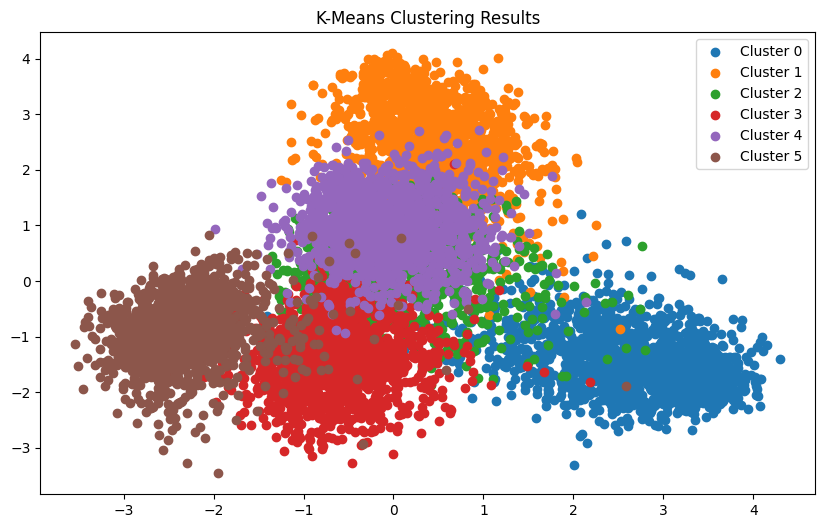

In [307]:
plot_2d(data=X_train, label=y_train, titel="K-Means")

### Model Training


```K-Means Clustering:```

K-Means is a popular unsupervised machine learning algorithm used for clustering, which involves grouping similar data points into clusters. The algorithm aims to partition the data into 'k' clusters, where each cluster is characterized by its centroid. The centroid represents the mean of all data points in the cluster.

```Algorithm Steps:```

- ```Initialization:``` Choose the number of clusters, 'k'.
Randomly initialize 'k' cluster centroids in the data space.
- ```Assignment Step:``` Assign each data point to the cluster whose centroid is closest in terms of Euclidean distance. This forms 'k' clusters.
- ```Update Centroids:``` Recalculate the centroids of each cluster by taking the mean of all data points assigned to that cluster.
- ```Repeat Steps 2 and 3:``` Iterate between the assignment and centroid update steps until convergence or a predefined number of iterations. Convergence occurs when the centroids no longer change significantly.

```Pros:```
- It is more efficient for large datasets.
- It is simpler to understand and implement.

```Cons:```
- It is sensitive to the initial placement of centroids.
- It assumes that clusters are convex and isotropic, which is not always the case.
- It is sensitive to outliers.

In [308]:
kmeans = KMeans(
    n_clusters=6,
    init="random",
    n_init=10,
    random_state=1,
).fit(X_train)
kmeans_y_pred = kmeans.predict(X_test)
kmeans_silhouette = silhouette_score(X_test, kmeans_y_pred)
kmeans_homogeneity = homogeneity_score(y_test, kmeans_y_pred)

```DBSCAN (Density-Based Spatial Clustering of Applications with Noise):```

DBSCAN is a density-based clustering algorithm designed to identify clusters of arbitrary shapes in a dataset. Unlike K-Means, DBSCAN does not assume clusters to be spherical and can discover clusters with varying shapes and sizes. It classifies data points into three categories: core points, border points, and noise points.

```Algorithm Steps:```

- ```Parameter Selection:``` Choose two parameters: epsilon (ε), the radius around each data point, and MinPts, the minimum number of points required to form a dense region.
- ```Core Point Identification:``` Identify core points by checking if a point has at least MinPts neighbors within its ε-radius.
- ```Cluster Formation:``` Form a cluster by connecting core points that are within each other's ε-radius. If two core points share neighbors, they belong to the same cluster.
- ```Border Point Assignment:``` Assign border points to the cluster of a reachable core point within their ε-radius.
- ```Noise Point Identification:``` Identify and label remaining points as noise.

```Pros:```
- It does not require the number of clusters to be specified in advance and can discover clusters of arbitrary shapes.
- It is more robust to noise and can handle clusters of varying densities.

```Cons:```
- It cannot efficiently handle high dimensional datasets.
- The quality of DBSCAN depends heavily on the distance measure used and the chosen parameters.

In [309]:
silhouette_eps_min_samples = []

for eps in DBSCAN_EPS_RANGE:
    for min_samples in DBSCAN_MIN_SAMPLES_RANGE:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train)
        y_pred = dbscan.fit_predict(X_test)
        if len(set(y_pred)) == 1:
            continue

        silhouette = silhouette_score(X_test, y_pred)
        homogeneity= homogeneity_score(y_test, y_pred)
        silhouette_eps_min_samples.append((silhouette, homogeneity, eps, min_samples))

### Metrics

```Homogeneity Score```

The Homogeneity Score is a metric designed to evaluate the quality of clustering results by assessing how well the clusters align with the true classes or labels of the data. Specifically, it measures the degree to which each cluster predominantly consists of data points from a single class, providing insights into the cohesion of clusters with respect to class membership.

steps of execution:
1. Assigning Data Points to Clusters
2. Computing Entropy of Class Labels
3. Computing Conditional Entropy of Class Labels Given Clusters
4. Calculating Homogeneity Score

$$H = \frac{1}{N} \sum \left(\frac{{\max(\text{{class\_count}})}}{{N_{\text{{cluster}}}}}\right)$$

where N is the total number of samples, N_cluster is the number of samples in the cluster, and max(class_count) is the count of the most frequent class label within the cluster.

```Silhouette Score```

The silhouette score evaluates the fitness of each sample within its assigned cluster and its distinctiveness from samples in neighboring clusters. This metric offers insights into both the cohesion within clusters and the separation between clusters. The silhouette score is a numerical measure that falls within the range of -1 to 1.

steps of execution:
1. For a given sample the average distance between that sample and all other samples within the same cluster is computed. This is known as the intra-cluster distance ($a$).
2. The average distance between that sample and all samples in the nearest neighboring cluster is calculated. This is known as the inter-cluster distance ($b$).
3. The silhouette score for the sample is computed using the formula:

$$\text{{silhouette\_score}} = \frac{{b - a}}{{\max(a, b)}}$$

- Steps 1-3 are repeated for each sample, and the average silhouette score across all samples is calculated to obtain the overall silhouette score for the clustering result.


print(f"Homogeneity is {kmeans_homogeneity}, Silhouette is {kmeans_silhouette}")
plot_2d(data=X_test, label=kmeans_y_pred, centers=kmeans.cluster_centers_, plot_centers=True, titel="K-Means")

Model: K-Means
	Homogeneity is 0.8259012422931351, Silhouette is 0.46346792578697205


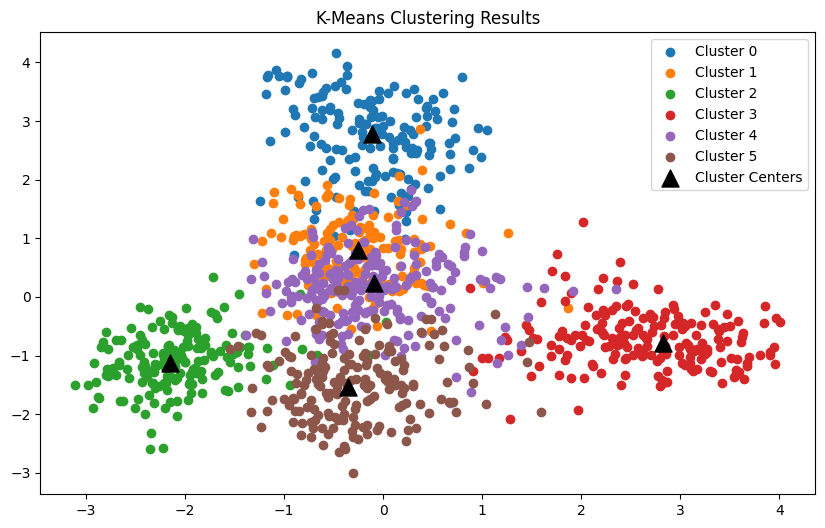

In [310]:
print("Model: K-Means")
print(f"\tHomogeneity is {kmeans_homogeneity}, Silhouette is {kmeans_silhouette}")
plot_2d(data=X_test, label=kmeans_y_pred, centers=kmeans.cluster_centers_, plot_centers=True, titel="K-Means")

Model: DBSCAN
	Maximum Silhouette Score: 0.35384652
	Parameters for Maximum Silhouette Score (eps, min_samples):  (0.9000000000000001,22)
	Homogeneity for these parameters is:  0.6841431473602945

	Maximum Homogeneity Score: 0.6841431473602945
	Parameters for Maximum Homogeneity Score (eps, min_samples):  (0.9000000000000001,22)
	Silhouette for these parameters is:  0.35384652

	Silhouette Score in Average Parameters:  0.35384652
	Homogeneity Score in Average Parameters:  0.6841431473602945
	Parameters for Maximum Average Parameters Score (eps, min_samples): (0.9000000000000001,22)


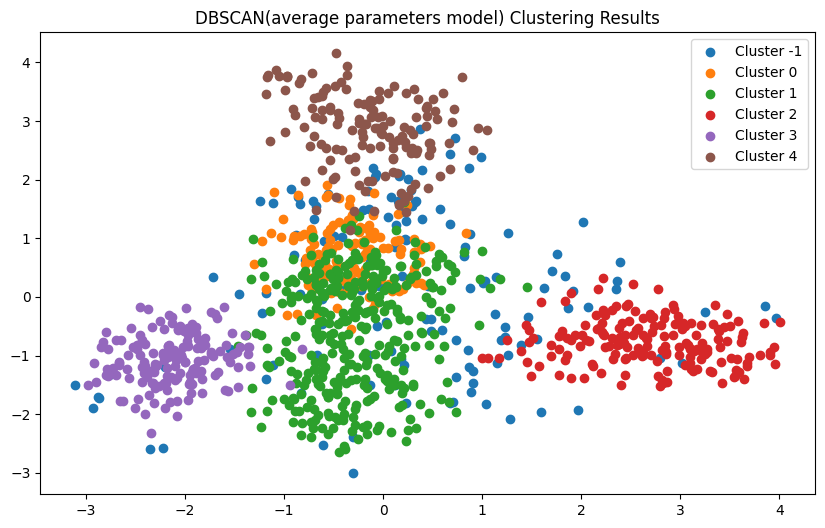

In [311]:
max_silhouette_params = max(silhouette_eps_min_samples, key=lambda x: x[0])

max_homogeneity_params = max(silhouette_eps_min_samples, key=lambda x: x[1])

max_avg_params = max(silhouette_eps_min_samples, key=lambda x: (x[0] + x[1]))

print("Model: DBSCAN")
print("\tMaximum Silhouette Score:", max_silhouette_params[0])
print(f"\tParameters for Maximum Silhouette Score (eps, min_samples):  ({max_silhouette_params[2]},{max_silhouette_params[3]})")
print("\tHomogeneity for these parameters is: ", max_silhouette_params[1])
print()
print("\tMaximum Homogeneity Score:", max_homogeneity_params[1])
print(f"\tParameters for Maximum Homogeneity Score (eps, min_samples):  ({max_homogeneity_params[2]},{max_homogeneity_params[3]})")
print("\tSilhouette for these parameters is: ", max_homogeneity_params[0])
print()
print("\tSilhouette Score in Average Parameters: ", max_avg_params[0])
print("\tHomogeneity Score in Average Parameters: ", max_avg_params[1])
print(f"\tParameters for Maximum Average Parameters Score (eps, min_samples): ({max_avg_params[2]},{max_avg_params[3]})")

dbscan = DBSCAN(eps=max_avg_params[2], min_samples=max_avg_params[3]).fit(X_train)
plot_2d(data=X_test, label=dbscan.fit_predict(X_test), titel="DBSCAN(average parameters model)")

### Comparison

The KMeans algorithm has demonstrated superior performance in clustering compared to DBSCAN. This conclusion is supported by a higher Homogeneity Score criterion, indicating its effectiveness in clustering. Moreover, the elevated Silhouette Score attests to KMeans' ability to generate clusters with improved intra-cluster and inter-cluster discriminability.

Several factors contribute to the observed performance discrepancy:

1. ```Algorithm Suitability:``` KMeans excels in scenarios where spherical clustering is preferred, whereas DBSCAN is adept at identifying more intricate and non-standard clusters. Given the nature of our problem, characterized by the need for simpler clusters, KMeans emerges as the more suitable choice.

2. ```Data Density:``` Our data exhibits areas of high density, posing a challenge for DBSCAN to accurately cluster. In such cases, KMeans proves advantageous in handling the dense distribution more effectively.

3. ```Feature Extraction Impact:``` During the feature extraction phase, certain text assignments may lead to values that result in sparse data. This sparsity can cause DBSCAN to classify them as outliers, impacting its clustering accuracy.

### How can we improve this model?

- `Feature Selection/Extraction`: Reducing the dimensionality of data can improve the speed and potentially the accuracy of models. Techniques such as PCA can be used.

- `Algorithm Modification`: There are improved versions of these algorithms that can be considered. For instance, an improved DBSCAN algorithm called K-DBSCAN applies an initial grouping to the data through the K-means++ algorithm, then employs DBSCAN to perform clustering in each group separately.

- `Larger Dataset`: Our corpus does not seem to be sufficiently large, resulting in the doc2vec model’s inability to extract satisfactory features. To improve the performance of our model, it may be necessary to procure a larger training dataset.

- `Using more Optimized Word feature extraction`: we can use a word feature extracter which is more reliable and update

- `Optimization Algorithms`: We can use optimization algorithms to improve the parameters of DBSCAN. For example, an efficient DBSCAN optimized by arithmetic optimization algorithm (OBLAOA-DBSCAN) can provide highly accurate clusters more efficiently.
